# Composite BKI Benchmark Analysis

This notebook visualizes the results from the Composite BKI benchmarking suite. It automatically loads the most recent results from each benchmark directory.

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import re
from pathlib import Path
from matplotlib.ticker import PercentFormatter

# Optional YAML parser (fallback parser included below)
try:
    import yaml
    _HAS_YAML = True
except Exception:
    _HAS_YAML = False

# Global plotting style (paper-friendly)
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# Figure export toggle (can be changed in the next cell)
SAVE_FIGURES = False
FIGURE_DIR = Path("figures")
FIGURE_FORMAT = "png"


def slugify(text):
    text = "figure" if text is None else str(text)
    text = re.sub(r"[^a-zA-Z0-9]+", "_", text).strip("_").lower()
    return text or "figure"


def maybe_save_figure(title=None):
    if not SAVE_FIGURES:
        return
    FIGURE_DIR.mkdir(parents=True, exist_ok=True)
    fname = f"{slugify(title)}.{FIGURE_FORMAT}"
    out = FIGURE_DIR / fname
    plt.savefig(out, bbox_inches="tight")
    print(f"Saved figure: {out}")


def get_latest_csv(folder_name):
    """Find the most recent CSV in a specific results folder."""
    search_path = Path(f"{folder_name}/*.csv")
    files = glob.glob(str(search_path))
    if not files:
        print(f"No results found in {folder_name}")
        return None
    latest_file = max(files, key=os.path.getctime)
    print(f"Loading: {latest_file}")
    return pd.read_csv(latest_file)


def get_latest_csv_pattern(folder_name, pattern):
    """Find the most recent CSV matching a pattern in folder."""
    search_path = Path(f"{folder_name}/{pattern}")
    files = glob.glob(str(search_path))
    if not files:
        print(f"No files matching {pattern} in {folder_name}")
        return None
    latest_file = max(files, key=os.path.getctime)
    print(f"Loading: {latest_file}")
    return pd.read_csv(latest_file)


def _pretty_label(name):
    if not isinstance(name, str):
        return str(name)
    return name.replace("-", " ").replace("_", " ").title()


def load_mcd_label_map(config_path=Path("../configs/mcd_config.yaml")):
    """Load raw_id -> class label map from mcd_config.yaml."""
    if not config_path.exists():
        print(f"Label config not found: {config_path}")
        return {}

    if _HAS_YAML:
        with open(config_path, "r") as f:
            cfg = yaml.safe_load(f)
        labels = cfg.get("labels", {})
        return {int(k): _pretty_label(v) for k, v in labels.items()}

    # Fallback parser for labels block only
    text = config_path.read_text().splitlines()
    in_labels = False
    labels = {}
    for line in text:
        if line.strip().startswith("labels:"):
            in_labels = True
            continue
        if in_labels and re.match(r"^[A-Za-z_].*:", line.strip()):
            # next top-level key reached
            break
        if in_labels:
            m = re.match(r"^\s*(\d+)\s*:\s*(.+?)\s*$", line)
            if m:
                labels[int(m.group(1))] = _pretty_label(m.group(2))
    return labels


LABEL_MAP = load_mcd_label_map()
print(f"Loaded {len(LABEL_MAP)} labels from mcd_config.yaml")


def map_class_id_to_name(class_id):
    try:
        return LABEL_MAP.get(int(class_id), f"Class {class_id}")
    except Exception:
        return str(class_id)


def finalize_plot(title=None, xlabel=None, ylabel=None, percent_y=False, legend_loc="best"):
    """Consistent axis styling for all benchmark figures."""
    ax = plt.gca()
    if title is not None:
        ax.set_title(title, pad=10, fontweight="bold")
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if percent_y:
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    if ax.get_legend() is not None:
        ax.legend(loc=legend_loc, frameon=True)
    plt.tight_layout()
    maybe_save_figure(title)



Loaded 29 labels from mcd_config.yaml


In [99]:
# Optional: enable figure export for paper assets
# Set SAVE_FIGURES = True to save every plot automatically.
SAVE_FIGURES = True
FIGURE_DIR = Path("figures")
FIGURE_FORMAT = "png"  # e.g., "png", "pdf", "svg"
print(f"SAVE_FIGURES={SAVE_FIGURES}, FIGURE_DIR={FIGURE_DIR}, FIGURE_FORMAT={FIGURE_FORMAT}")


SAVE_FIGURES=True, FIGURE_DIR=figures, FIGURE_FORMAT=png


## 1. Multi-Scan Convergence
How does map quality improve as more scans are integrated?

Loading: multi_scan_results/multi_scan_benchmark_20260216_120951.csv
Saved figure: figures/map_convergence_over_time.png


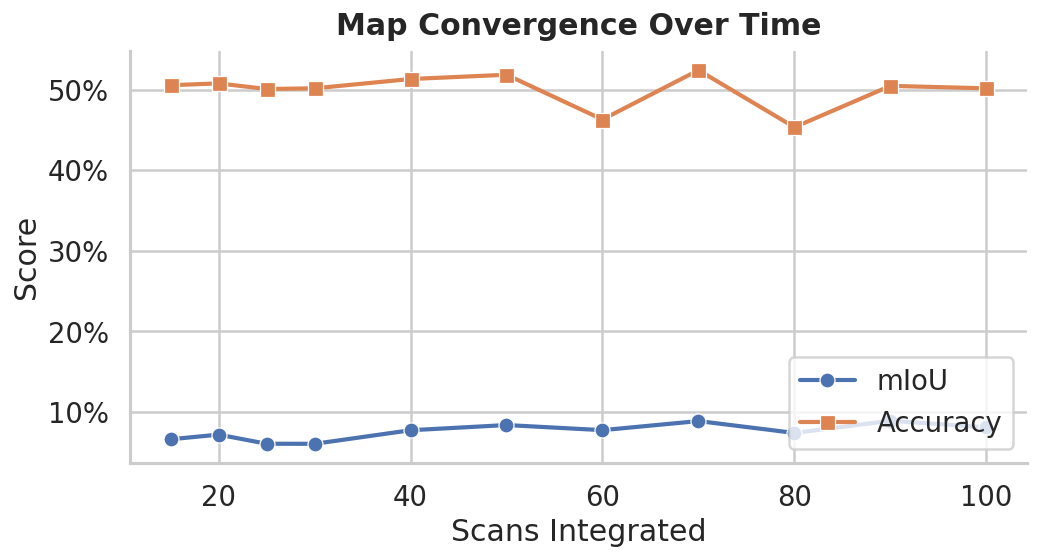

In [100]:
df_multi = get_latest_csv("multi_scan_results")

if df_multi is not None:
    df_multi = df_multi.sort_values("scans_integrated")

    fig, ax = plt.subplots(figsize=(9, 5))
    sns.lineplot(data=df_multi, x="scans_integrated", y="miou", marker="o", linewidth=2.5, label="mIoU", ax=ax)
    sns.lineplot(data=df_multi, x="scans_integrated", y="accuracy", marker="s", linewidth=2.5, label="Accuracy", ax=ax)

    finalize_plot(
        title="Map Convergence Over Time",
        xlabel="Scans Integrated",
        ylabel="Score",
        percent_y=True,
        legend_loc="lower right",
    )
    plt.show()

## 2. Forgetting Factor Sweep
Does the forgetting mechanism (lambda decay) help or hurt long-term stability?

Loading: forgetting_results/forgetting_benchmark_20260216_121859.csv


Saved figure: figures/effect_of_forgetting_configuration_on_miou.png


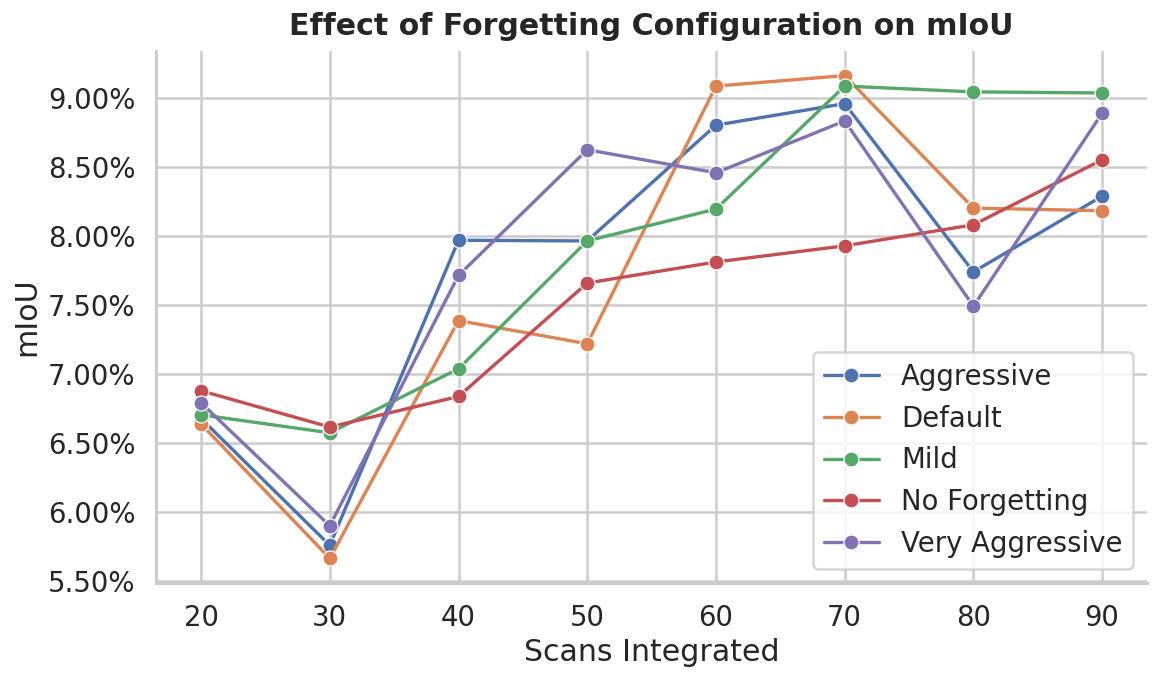

In [101]:
df_forget = get_latest_csv("forgetting_results")

if df_forget is not None:
    df_forget = df_forget.sort_values(["config", "scans_integrated"])
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_forget,
        x="scans_integrated",
        y="miou",
        hue="config",
        marker="o",
        linewidth=2,
    )
    finalize_plot(
        title="Effect of Forgetting Configuration on mIoU",
        xlabel="Scans Integrated",
        ylabel="mIoU",
        percent_y=True,
        legend_loc="lower right",
    )
    plt.show()

## 3. OSM Integration Modes
Which OSM integration strategy works best?

In [102]:
df_osm = get_latest_csv("osm_modes_results")

if df_osm is not None:
    max_scan = df_osm["scans_integrated"].max()
    df_final = df_osm[df_osm["scans_integrated"] == max_scan].copy()
    df_final = df_final.sort_values("miou", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_final, x="config", y="miou", palette="Blues_r")
    finalize_plot(
        title=f"OSM Integration Strategies at Final Checkpoint (scan {max_scan})",
        xlabel="Configuration",
        ylabel="mIoU",
        percent_y=True,
    )
    plt.xticks(rotation=30, ha="right")
    plt.show()

No results found in osm_modes_results


## 4. Parameter Sensitivity
Impact of hyperparameters on Accuracy and Runtime.

In [103]:
df_params = get_latest_csv("parameter_sensitivity_results")

if df_params is not None:
    params = sorted(df_params["parameter"].unique())

    for param in params:
        subset = df_params[df_params["parameter"] == param].copy().sort_values("value")

        fig, ax1 = plt.subplots(figsize=(9, 5))
        sns.lineplot(data=subset, x="value", y="miou", marker="o", color="tab:blue", linewidth=2.5, ax=ax1, label="mIoU")
        ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax1.set_xlabel(param)
        ax1.set_ylabel("mIoU")

        ax2 = ax1.twinx()
        sns.lineplot(data=subset, x="value", y="time_elapsed", marker="x", color="tab:red", linewidth=2.0, ax=ax2, label="Runtime (s)")
        ax2.set_ylabel("Runtime (s)")

        ax1.set_title(f"Parameter Sensitivity: {param}", fontweight="bold")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1 + h2, l1 + l2, loc="best", frameon=True)
        plt.tight_layout()
        plt.show()

No results found in parameter_sensitivity_results


## 5. Throughput & Scaling
Performance analysis: Threads, Point Density, and Resolution.

Loading: throughput_results/throughput_benchmark_20260216_105923.csv
Saved figure: figures/throughput_vs_threads.png


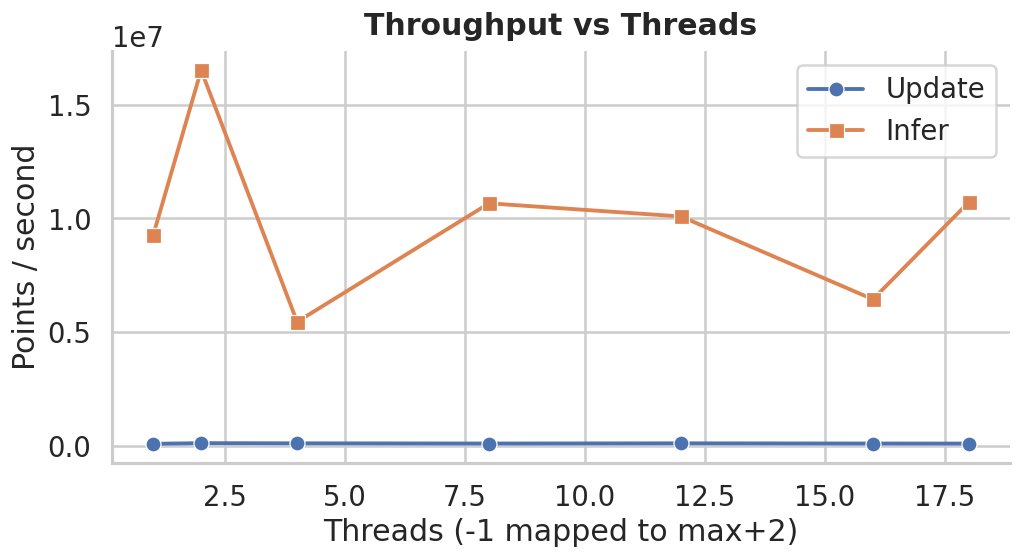

Saved figure: figures/execution_time_vs_point_cloud_size.png


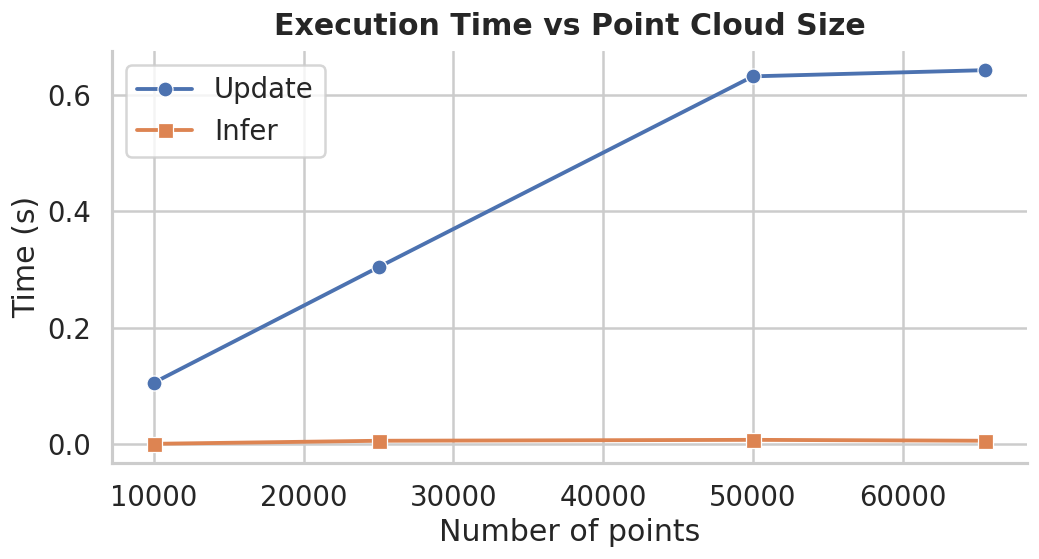

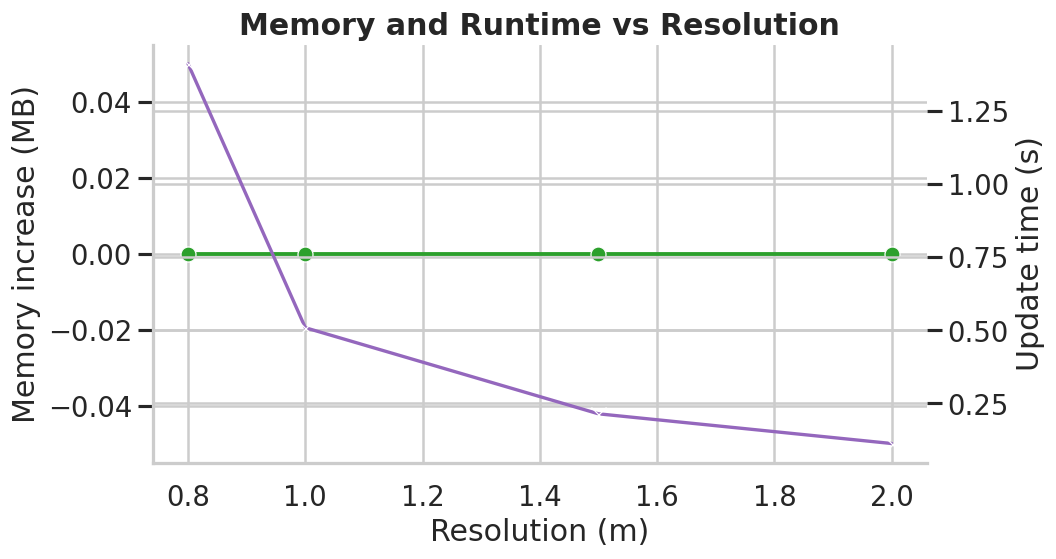

In [104]:
df_throughput = get_latest_csv("throughput_results")

if df_throughput is not None:
    # 1) Thread scaling
    df_threads = df_throughput[df_throughput["experiment"] == "thread_scaling"].copy()
    if not df_threads.empty:
        df_threads = df_threads.sort_values("threads")
        # Keep max-threads marker readable
        max_threads = df_threads[df_threads["threads"] != -1]["threads"].max()
        df_threads.loc[df_threads["threads"] == -1, "threads"] = max_threads + 2

        plt.figure(figsize=(9, 5))
        sns.lineplot(data=df_threads, x="threads", y="update_throughput", marker="o", linewidth=2.3, label="Update")
        sns.lineplot(data=df_threads, x="threads", y="infer_throughput", marker="s", linewidth=2.3, label="Infer")
        finalize_plot(
            title="Throughput vs Threads",
            xlabel="Threads (-1 mapped to max+2)",
            ylabel="Points / second",
            legend_loc="best",
        )
        plt.show()

    # 2) Point scaling
    df_points = df_throughput[df_throughput["experiment"] == "point_scaling"].copy()
    if not df_points.empty:
        df_points = df_points.sort_values("points")
        plt.figure(figsize=(9, 5))
        sns.lineplot(data=df_points, x="points", y="update_time", marker="o", linewidth=2.3, label="Update")
        sns.lineplot(data=df_points, x="points", y="infer_time", marker="s", linewidth=2.3, label="Infer")
        finalize_plot(
            title="Execution Time vs Point Cloud Size",
            xlabel="Number of points",
            ylabel="Time (s)",
            legend_loc="upper left",
        )
        plt.show()

    # 3) Resolution scaling
    df_res = df_throughput[df_throughput["experiment"] == "resolution_scaling"].copy()
    if not df_res.empty:
        df_res = df_res.sort_values("resolution")
        fig, ax1 = plt.subplots(figsize=(9, 5))
        sns.lineplot(data=df_res, x="resolution", y="memory_increase_mb", marker="o", color="tab:green", linewidth=2.3, ax=ax1)
        ax1.set_xlabel("Resolution (m)")
        ax1.set_ylabel("Memory increase (MB)")

        ax2 = ax1.twinx()
        sns.lineplot(data=df_res, x="resolution", y="update_time", marker="x", color="tab:purple", linewidth=2.0, ax=ax2)
        ax2.set_ylabel("Update time (s)")

        ax1.set_title("Memory and Runtime vs Resolution", fontweight="bold")
        plt.tight_layout()
        plt.show()

## 6. Per-Class Improvement
Which classes benefit most from BKI?

In [ ]:
df_class = get_latest_csv_pattern("per_class_results", "per_class_iou_*.csv")

if df_class is not None:
    required_cols = ["class_id", "Baseline", "BKI_Only", "BKI_OSM"]
    if all(c in df_class.columns for c in required_cols):
        df_plot = df_class[required_cols].copy().sort_values("class_id")
        df_plot["class_name"] = df_plot["class_id"].map(map_class_id_to_name)

        df_long = df_plot.melt(id_vars=["class_id", "class_name"], var_name="Method", value_name="IoU")

        plt.figure(figsize=(16, 6))
        sns.barplot(data=df_long, x="class_name", y="IoU", hue="Method", palette="Set2")
        plt.xticks(rotation=45, ha="right")
        finalize_plot(
            title="Per-Class IoU by Method (MCD labels)",
            xlabel="Class",
            ylabel="IoU",
            percent_y=True,
            legend_loc="upper right",
        )
        plt.show()

        if "BKI_OSM_Imp" in df_class.columns:
            df_imp = df_class[["class_id", "BKI_OSM_Imp"]].copy()
            df_imp["class_name"] = df_imp["class_id"].map(map_class_id_to_name)
            df_imp = df_imp.sort_values("BKI_OSM_Imp", ascending=False)

            plt.figure(figsize=(12, 7))
            sns.barplot(data=df_imp, y="class_name", x="BKI_OSM_Imp", palette="RdBu_r")
            plt.axvline(0, color="black", linewidth=1)
            finalize_plot(
                title="Per-Class Improvement (BKI+OSM minus Baseline)",
                xlabel="IoU delta",
                ylabel="Class",
                percent_y=True,
            )
            plt.show()
    else:
        print("Unexpected per_class_results schema. Available columns:")
        print(df_class.columns.tolist())

Loading: per_class_results/per_class_iou_20260216_115156.csv


## 7. Predicted vs GT Input
Denoising (Pred Input) vs Fusion (GT Input) capabilities.

In [ ]:
df_pred_gt = get_latest_csv("pred_vs_gt_results")

if df_pred_gt is not None:
    df_pred_gt = df_pred_gt.sort_values(["input_source", "scans_integrated"])
    plt.figure(figsize=(9, 5))
    sns.lineplot(data=df_pred_gt, x="scans_integrated", y="miou", hue="input_source", marker="o", linewidth=2.3)
    finalize_plot(
        title="Predicted vs Ground-Truth Inputs",
        xlabel="Scans Integrated",
        ylabel="mIoU (evaluated vs GT)",
        percent_y=True,
        legend_loc="lower right",
    )
    plt.show()

No results found in pred_vs_gt_results


## 8. Calibration (Reliability Diagram)
Are the predicted probabilities trustworthy?

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Loading: calibration_results/calibration_bins_20260216_111350.csv


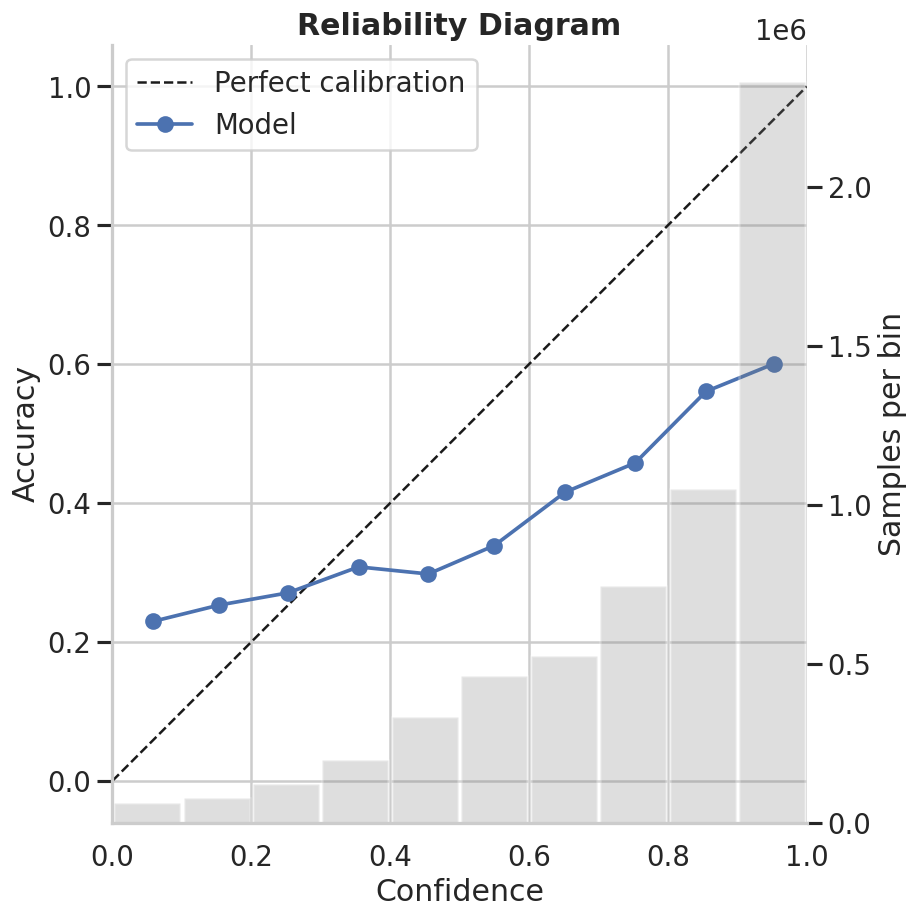

In [ ]:
df_calib = get_latest_csv("calibration_results")

if df_calib is not None:
    df_calib = df_calib.sort_values("confidence")

    fig, ax1 = plt.subplots(figsize=(8, 8))
    ax1.plot([0, 1], [0, 1], "k--", linewidth=1.5, label="Perfect calibration")
    ax1.plot(df_calib["confidence"], df_calib["accuracy"], "o-", linewidth=2.2, label="Model")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_aspect("equal", adjustable="box")
    ax1.set_xlabel("Confidence")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Reliability Diagram", fontweight="bold")
    ax1.legend(loc="upper left", frameon=True)

    # Confidence distribution overlay (scaled to secondary axis)
    if "samples" in df_calib.columns and "lower" in df_calib.columns and "upper" in df_calib.columns:
        centers = 0.5 * (df_calib["lower"] + df_calib["upper"])
        widths = (df_calib["upper"] - df_calib["lower"]).clip(lower=1e-6)
        ax2 = ax1.twinx()
        ax2.bar(centers, df_calib["samples"], width=widths * 0.95, alpha=0.25, color="tab:gray", label="Samples/bin")
        ax2.set_ylabel("Samples per bin")
        ax2.grid(False)

    plt.tight_layout()
    plt.show()

## 9. Temporal Consistency
Map stability over time (Label Flip Rate).

Loading: temporal_consistency_results/temporal_consistency_20260216_111550.csv


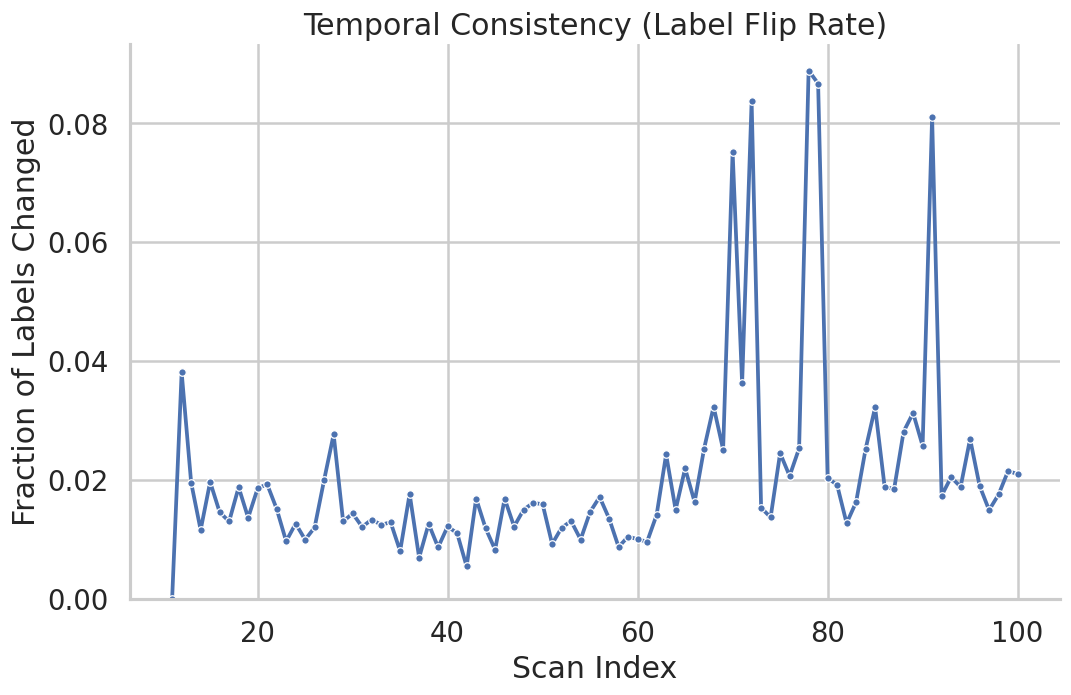

In [ ]:
df_temp = get_latest_csv("temporal_consistency_results")

if df_temp is not None:
    plt.figure()
    sns.lineplot(data=df_temp, x='scan_idx', y='flip_rate', marker='.')
    plt.title('Temporal Consistency (Label Flip Rate)')
    plt.ylabel('Fraction of Labels Changed')
    plt.xlabel('Scan Index')
    plt.ylim(bottom=0)
    plt.show()

## 10. Quantitative Results Table
Paper-style per-class table (like your example): methods as rows, class IoU columns + mIoU/Acc summary (MCD labels).

In [ ]:
def build_per_class_paper_table(per_class_df, summary_df, dataset_name="MCD"):
    """
    Build table like the paper screenshot:
    rows = methods, columns = per-class IoU + summary metrics.
    """
    method_order = ["Baseline", "NoSem_BKI", "NoSem_BKI_OSM", "BKI_Only", "BKI_OSM"]

    # Resolve per-class display names
    per_class = per_class_df.copy().sort_values("class_id")
    per_class["class_name"] = per_class["class_id"].map(map_class_id_to_name)

    class_cols = ["Baseline", "NoSem_BKI", "NoSem_BKI_OSM", "BKI_Only", "BKI_OSM"]
    class_cols = [c for c in class_cols if c in per_class.columns]

    # Method x class matrix
    class_matrix = per_class.set_index("class_name")[class_cols].T
    class_matrix.index.name = "Method"

    # Summary metrics
    s = summary_df.copy()
    s["mIoU"] = (s["mIoU"] * 100).round(1)
    s["Accuracy"] = (s["Accuracy"] * 100).round(1)
    s = s.set_index("Method")[["mIoU", "Accuracy"]]

    # Convert class IoUs to percentage
    class_matrix = (class_matrix * 100).round(1)

    # Optional extra: gain vs baseline mIoU (percentage points)
    baseline_miou = s.loc["Baseline", "mIoU"] if "Baseline" in s.index else np.nan
    gain = (s["mIoU"] - baseline_miou).round(1)

    # Combine into one table
    table = pd.concat([class_matrix, s, gain.rename("Gain")], axis=1)

    # Enforce method ordering
    table["_order"] = pd.Categorical(table.index, categories=method_order, ordered=True)
    table = table.sort_values("_order").drop(columns=["_order"])

    # Build grouped MultiIndex columns
    per_class_names = list(class_matrix.columns)
    grouped_cols = [
        ("", "Method"),
        *[("Per-class IoU (%)", c) for c in per_class_names],
        ("Summary", "mIoU (%)"),
        ("Summary", "Acc (%)"),
        ("Summary", "Gain"),
    ]

    out = table.reset_index().copy()
    out.columns = pd.MultiIndex.from_tuples(grouped_cols)
    return out


df_per_class = get_latest_csv_pattern("per_class_results", "per_class_iou_*.csv")
df_summary = get_latest_csv_pattern("method_summary_results", "method_summary_*.csv")

if df_per_class is not None and df_summary is not None:
    paper_table = build_per_class_paper_table(df_per_class, df_summary, dataset_name="MCD")

    from IPython.display import display

    # Highlight best values in summary columns and per-class columns
    def highlight_best_col(col):
        if col.name[0] in ["Per-class IoU (%)", "Summary"] and col.name[1] != "Method":
            numeric = pd.to_numeric(col, errors="coerce")
            mx = np.nanmax(numeric.values)
            return ["font-weight: bold" if (pd.notna(v) and float(v) == float(mx)) else "" for v in numeric.values]
        return ["" for _ in col.values]

    styled = (
        paper_table.style
        .format(na_rep="-")
        .apply(highlight_best_col, axis=0)
        .hide(axis="index")
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "center"), ("font-size", "10pt")]},
            {"selector": "td", "props": [("text-align", "center"), ("font-size", "9pt")]},
            {"selector": "thead th", "props": [("border-bottom", "1px solid #999")]},
        ])
    )
    display(styled)

    print("\nLaTeX preview:")
    print(paper_table.to_latex(index=False, multicolumn=True, multicolumn_format='c'))
else:
    print("Need both per_class_results and method_summary_results to build the table.")

Loading: per_class_results/per_class_iou_20260216_115156.csv
Loading: method_summary_results/method_summary_20260216_115156.csv



LaTeX preview:
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{26}{c}{Per-class IoU (%)} & \multicolumn{3}{c}{Summary} \\
Method & Barrier & Bike & Building & Chair & Cliff & Container & Curb & Fence & Infosign & Lanemarking & Noise & Other & Parkinglot & Pedestrian & Pole & Road & Sidewalk & Stairs & Structure Other & Traffic Sign & Trashbin & Treetrunk & Vegetation & Vehicle Dynamic & Vehicle Other & Vehicle Static & mIoU (%) & Acc (%) & Gain \\
\midrule
Baseline & 0.000000 & 2.300000 & 70.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.500000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 3.500000 & 1.700000 & 0.100000 & 12.900000 & 0.000000 & 0.000000 & 8.100000 & 0.000000 & 18.900000 & 33.000000 & 0.000000 & 0.000000 & 0.000000 & 6.000000 & 44.600000 & 0.000000 \\
NoSem_BKI & 0.000000 & 0.900000 & 71.800000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.300000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 2.000000 & 0.200000 &